<a href="https://colab.research.google.com/github/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam
import PIL
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

In [82]:
!wget https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/dataset_reduced.zip?raw=true  -O data.zip
!unzip data.zip

--2020-08-16 00:00:49--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/dataset_reduced.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/dataset_reduced.zip [following]
--2020-08-16 00:00:49--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/dataset_reduced.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/master/dataset_reduced.zip [following]
--2020-08-16 00:00:49--  https://raw.githubusercontent.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/master/dataset_reduced.zip
Resolving raw

In [83]:
SIZE_X = int(1024 / 8)
SIZE_Y = int(768 / 8)

x = np.load( "train_images_small.npy")
x = x.reshape(2935, SIZE_Y, SIZE_X, 1)
y = np.load('bounding_box_small.npy')
y[:, 0], y[:, 1] = y[:, 0] , y[:,1]
y[:, 2], y[:, 3] = y[:, 2] , y[:,3]

metadeta = pd.read_csv('metadeta.csv')
print(x.shape)
data_size = x.shape[0]

augmented_meta_deta = {'subj' : [], 'augmented' : []}

(2935, 96, 128, 1)


In [84]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random



def translate(image, predicted, show = False):
  new_bb = np.copy(predicted)
  start_x = int(predicted[0] * 0.9)
  start_y = int(predicted[2] * 0.9)
  end_x = int(predicted[1] * 0.9)
  end_y = int(predicted[3] * 0.9)

  
  new_x = random.randint(-start_x , SIZE_X - end_x)
  new_y = random.randint(-start_y , SIZE_Y - end_y)

  image = np.reshape(image, (SIZE_Y, SIZE_X))

  translation_matrix = np.float32([ [1,0, new_x], [0,1, new_y] ])
  img_translation = cv2.warpAffine(image, translation_matrix, (SIZE_X, SIZE_Y))

  new_bb[0], new_bb[1] = new_bb[0] + new_x, new_bb[1] + new_x
  new_bb[2], new_bb[3] = new_bb[2] + new_y, new_bb[3] + new_y

  if new_bb[0] > SIZE_X:
    new_bb[0] = SIZE_X
  if new_bb[1] > SIZE_X:
    new_bb[1] = SIZE_X
  if new_bb[2] > SIZE_Y:
    new_bb[2] = SIZE_Y
  if new_bb[3] > SIZE_Y:
    new_bb[3] = SIZE_Y

  if show:
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[10,10])
    ax[0].imshow(image)
    ax[1].imshow(img_translation)
    rect = patches.Rectangle((predicted[0] ,predicted[2] ),(predicted[1] - predicted[0]) ,(predicted[3] - predicted[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[0].add_patch(rect)


    new_rect = patches.Rectangle((new_bb[0] ,new_bb[2] ),(new_bb[1] - new_bb[0]) ,(new_bb[3] - new_bb[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[1].add_patch(new_rect) 


    plt.show()
  return np.reshape(img_translation, (SIZE_Y, SIZE_X, 1)), new_bb

In [85]:
def scale(image, predicted, show = False):
  image = np.reshape(image, (SIZE_Y, SIZE_X))
  img_shape = image.shape
  canvas = np.zeros(img_shape, dtype = np.uint8)

  scale = random.uniform(-0.5, 0.5)
  resize_scale_x = 1 + scale
  resize_scale_y = 1 + scale
 
  img=  cv2.resize(image, None, fx = resize_scale_x, fy = resize_scale_y)
  new_bb = predicted * resize_scale_x

  y_lim = int(min(resize_scale_y,1)*img_shape[0])
  x_lim = int(min(resize_scale_x,1)*img_shape[1])

  canvas[:y_lim,:x_lim] =  img[:y_lim,:x_lim]

  img = canvas

  if new_bb[0] > SIZE_X:
    new_bb[0] = SIZE_X
  if new_bb[1] > SIZE_X:
    new_bb[1] = SIZE_X
  if new_bb[2] > SIZE_Y:
    new_bb[2] = SIZE_Y
  if new_bb[3] > SIZE_Y:
    new_bb[3] = SIZE_Y
  
  if show:
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[10,10])
    ax[0].imshow(image)
    ax[1].imshow(canvas)
    rect = patches.Rectangle((predicted[0] ,predicted[2] ),(predicted[1] - predicted[0]) ,(predicted[3] - predicted[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[0].add_patch(rect)


    new_rect = patches.Rectangle((new_bb[0] ,new_bb[2] ),(new_bb[1] - new_bb[0]) ,(new_bb[3] - new_bb[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[1].add_patch(new_rect) 


    plt.show()

  return np.reshape(img, (SIZE_Y, SIZE_X, 1)), new_bb


In [86]:
augmented_x = np.zeros((data_size * 5, SIZE_Y, SIZE_X, 1))
augmented_y = np.zeros((data_size * 5, 4))

n = 0
for i, row in metadeta.iterrows():
  subj = row['subj']
  augmented_x[n] = x[i]
  augmented_y[n] = y[i]
  n += 1
  for _ in range(4):
    show = False
    if random.random() < 0.5:
      augmented_x[n], augmented_y[n] = translate(x[i], y[i], show = show)
    else:
      augmented_x[n], augmented_y[n] = scale(x[i], y[i], show = show)
    n += 1
  augmented_meta_deta['subj'].extend([subj] * 5)
  augmented_meta_deta['augmented'].extend([0, 1, 1, 1, 1])






In [87]:
augmented_meta_deta = pd.DataFrame.from_dict(augmented_meta_deta)
augmented_meta_deta.to_csv("augmented_metadeta.csv")
np.save('augmented_img', augmented_x)
np.save('augmented_y', augmented_y)

In [88]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam
import PIL
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

augmented_x = np.load('augmented_img.npy')
augmented_y = np.load('augmented_y.npy')

augmented_x /= 255
augmented_y[:,0], augmented_y[:, 1] = (augmented_y[:,0] - 5) / SIZE_X, (augmented_y[:, 1] + 5)/ SIZE_X
augmented_y[:,2], augmented_y[:, 3] = (augmented_y[:,2] - 5) / SIZE_Y, (augmented_y[:, 3] + 5) / SIZE_Y


metadeta = pd.read_csv('augmented_metadeta.csv')
print(metadeta.head(10))
subjects = (list(set(metadeta['subj'])))
n = len(subjects)
train_subjects = np.random.choice(subjects, size = int(n * 0.7), replace = False)
left_subjects = list(set(subjects) - set(train_subjects))
validation_subjects = np.random.choice(left_subjects, size = int(len(left_subjects) * 0.5), replace = False)
test_subjects = list(set(subjects) - (set(train_subjects).union(set(validation_subjects))))

train_indices = np.isin(metadeta['subj'], train_subjects)
train_indices = [i for i in range(metadeta['subj'].shape[0]) if train_indices[i]]

train_x = np.zeros((len(train_indices), SIZE_Y, SIZE_X, 1))
train_y = np.zeros((len(train_indices), 4))
count = 0

print(train_subjects, validation_subjects, test_subjects)


for i in train_indices:
  train_x[count] = augmented_x[i]
  train_y[count] = augmented_y[i]
  count += 1

valid_indices = np.logical_and(np.isin(metadeta['subj'], validation_subjects), metadeta['augmented'] == 0)
valid_indices = [i for i in range(metadeta['subj'].shape[0]) if valid_indices[i]]

valid_x = np.zeros((len(valid_indices), SIZE_Y, SIZE_X, 1))
valid_y = np.zeros((len(valid_indices), 4))
count = 0

for i in valid_indices:
  valid_x[count] = augmented_x[i]
  valid_y[count] = augmented_y[i]
  count += 1

test_indices = np.logical_and(np.isin(metadeta['subj'], test_subjects), metadeta['augmented'] == 0)
test_indices = [i for i in range(metadeta['subj'].shape[0]) if test_indices[i]]

test_x = np.zeros((len(test_indices), SIZE_Y, SIZE_X, 1))
test_y = np.zeros((len(test_indices), 4))
count = 0

for i in test_indices:
  test_x[count] = augmented_x[i]
  test_y[count] = augmented_y[i]
  count += 1



print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)
print(test_y)

   Unnamed: 0  subj  augmented
0           0     1          0
1           1     1          1
2           2     1          1
3           3     1          1
4           4     1          1
5           5     1          0
6           6     1          1
7           7     1          1
8           8     1          1
9           9     1          1
[14 92 11 71 45 50 88 22 33 68 23  4 21 73  7 42 10  3 20 87 81 52 65 17
 31 28 90 57 25 15 18 43 16 41 84 19 80 93  6 37 86  5 69 66 79 85 75 24
 54 58 70 27  1 44 83 77  9 61  2 34 74 48] [94 35 39 64 29 32 51 40 26 89 55 67 13] [36, 38, 8, 72, 12, 76, 46, 78, 82, 53, 62, 91, 30, 63]
(10420, 96, 128, 1)
(10420, 4)
(453, 96, 128, 1)
(453, 4)
(398, 96, 128, 1)
(398, 4)
[[0.29613945 0.65569183 0.25212935 0.73798698]
 [0.27616729 0.6314824  0.25777805 0.74282893]
 [0.24106462 0.60424776 0.24970847 0.72507565]
 ...
 [0.32470009 0.72150278 0.4361158  0.93685912]
 [0.32863113 0.72545678 0.43340832 0.93660923]
 [0.32680113 0.72794799 0.43229989 0.93930896]]

No handles with labels found to put in legend.


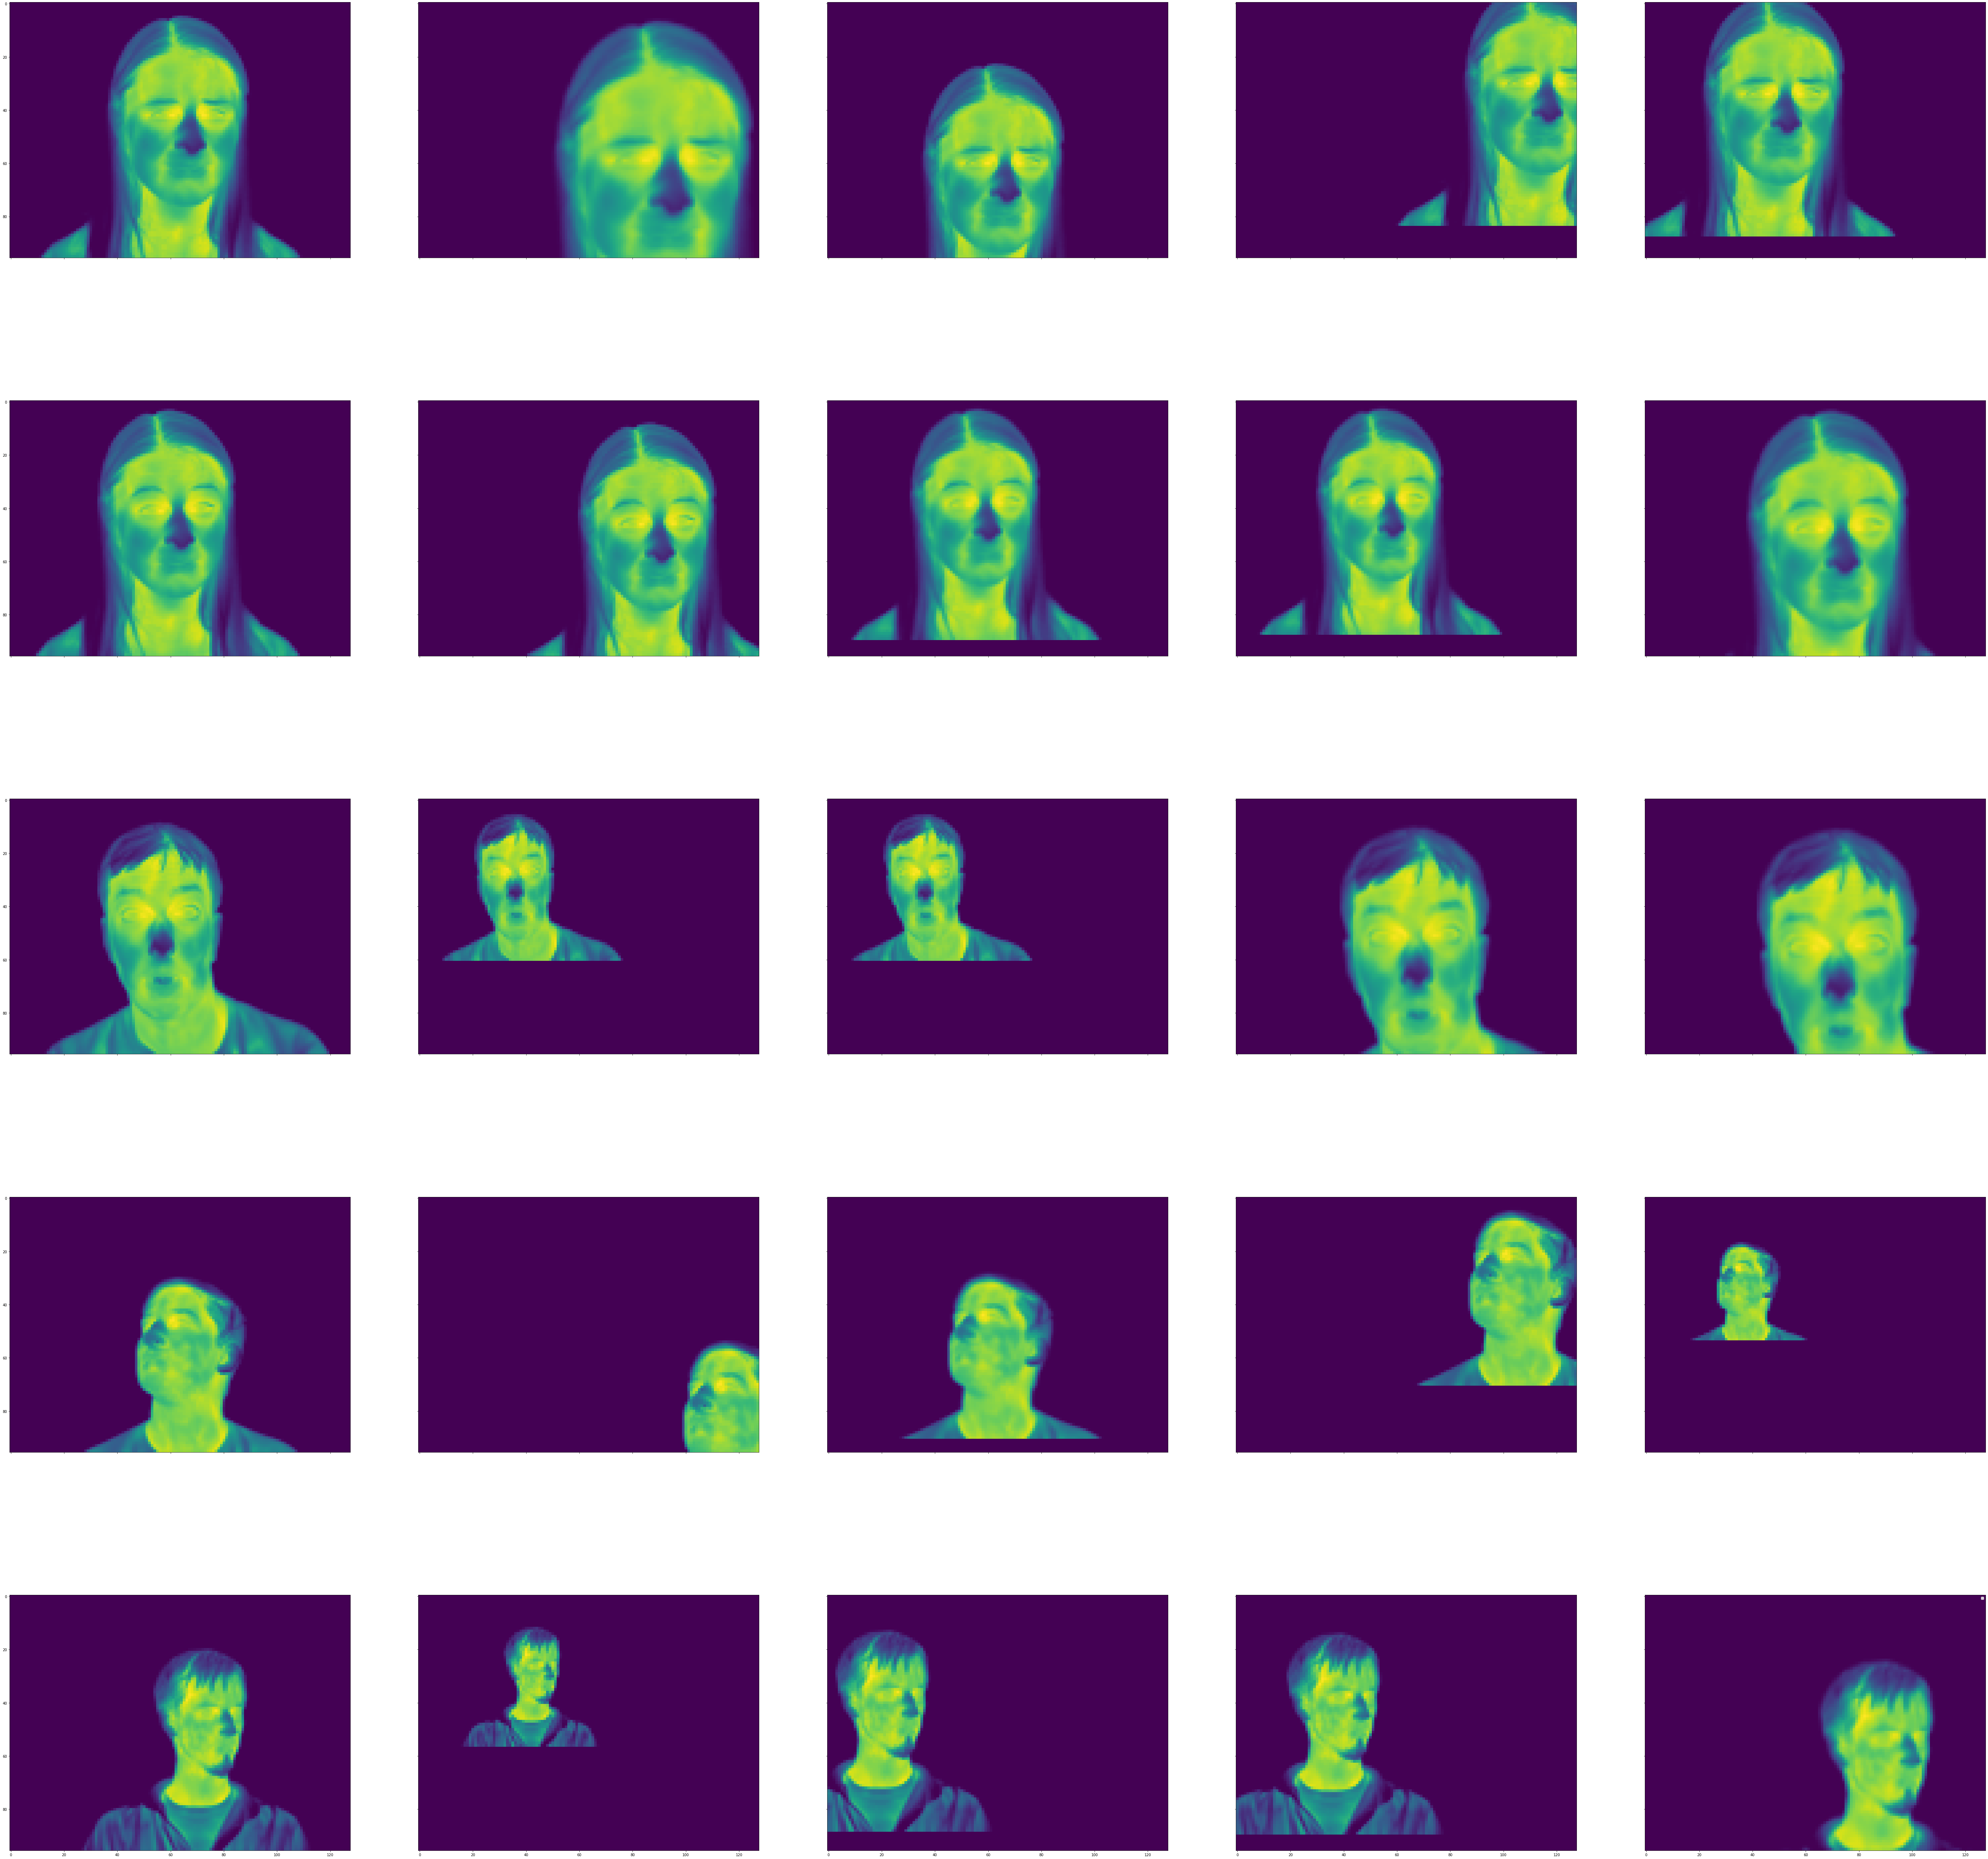

In [89]:
  import matplotlib.pyplot as plt
  nrows = 5
  ncols = 5
  n = 0
  irand=(np.random.choice(train_x.shape[0],nrows)//5) * 5
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[100,100])
  for row in range(nrows):
    for col in range(ncols):

      if col == 0:
        to_image = np.reshape(train_x[irand[n]], (SIZE_Y, SIZE_X)) * 255
        ax[row,col].imshow(to_image)
      else:
        to_image = np.reshape(train_x[irand[n] + col], (SIZE_Y, SIZE_X)) * 255
        ax[row,col].imshow(to_image)
    n += 1
         
  plt.legend()
  plt.show()

Epoch 1/500
163/163 [==============================] - 5s 33ms/step - loss: 0.1270 - val_loss: 0.0369
Epoch 2/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0723 - val_loss: 0.0275
Epoch 3/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0579 - val_loss: 0.0272
Epoch 4/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0502 - val_loss: 0.0235
Epoch 5/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0452 - val_loss: 0.0209
Epoch 6/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0419 - val_loss: 0.0198
Epoch 7/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0394 - val_loss: 0.0192
Epoch 8/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0374 - val_loss: 0.0194
Epoch 9/500
163/163 [==============================] - 5s 30ms/step - loss: 0.0359 - val_loss: 0.0189
Epoch 10/500
163/163 [==============================] - 5s 30ms/step - loss: 0.034

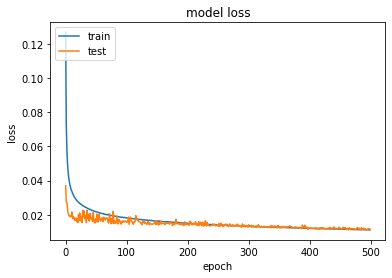

In [90]:
from tensorflow.keras import regularizers
model3 = Sequential()
model3.add(Conv2D(32, (2, 2), padding = 'same', activation='tanh', input_shape=(SIZE_Y, SIZE_X, 1)))

model3.add(Conv2D(32, (2, 2), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
#model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
#model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='tanh'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Conv2D(256, (3, 3), activation='tanh'))
model3.add(Conv2D(256, (5, 5), activation='relu'))
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
#model3.add(Dropout(0.5))
model3.add(Dense(4, activation='sigmoid'))

sgd = Adam(lr=1e-5)
model3.compile(loss='mean_absolute_error', optimizer=sgd)
history = model3.fit(train_x, train_y, batch_size=64, epochs=500, validation_data = (valid_x, valid_y), verbose = 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [91]:
def plot_predictions(predicted_set):
  n = 0
  nrows = 4
  ncols = 4
  irand=np.random.choice(test_y.shape[0],nrows*ncols)
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[100,100])
  for row in range(nrows):
    for col in range(ncols):

      to_image = np.reshape(test_x[irand[n]], (SIZE_Y, SIZE_X)) * 255
      ax[row,col].imshow(to_image)

      # Create a Rectangle patch
      predicted = list(predicted_set[irand[n]])
      #print(predicted[0] *SIZE_X, predicted[1] * SIZE_X, predicted[2] * SIZE_Y,predicted[3] * SIZE_Y)
      rect = patches.Rectangle((predicted[0] * SIZE_X,predicted[2] * SIZE_Y),(predicted[1] - predicted[0]) * SIZE_X,(predicted[3] - predicted[2])*SIZE_Y,linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
      # Add the patch to the Axes
      ax[row,col].add_patch(rect)

      predicted = list(test_y[irand[n]])
      #print(predicted[0] *SIZE_X, predicted[1] * SIZE_X, predicted[2] * SIZE_Y,predicted[3] * SIZE_Y)
      rect = patches.Rectangle((predicted[0] * SIZE_X,predicted[2] * SIZE_Y),(predicted[1] - predicted[0]) * SIZE_X,(predicted[3] - predicted[2])*SIZE_Y,linewidth=10,edgecolor='y',facecolor='none', label = 'actual')
      # Add the patch to the Axes
      ax[row,col].add_patch(rect)
      n += 1
         
  plt.legend()
  plt.show()

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[2], boxB[2])
	xB = min(boxA[1], boxB[1])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
	boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def intersection_over_union_set(setA, setB):
  iou = []
  n = setA.shape[0]
  assert setA.shape[0] == setB.shape[0]
  for i in range(n):
    b = bb_intersection_over_union(setA[i], setB[i])
    iou.append(b)

  x = [i * 0.01 for i in range(1, 100)]
  y = [sum([1 for i in iou if i > selected_x])/len(iou) for selected_x in x]
  plt.plot(x, y)
  plt.grid()
  plt.show()

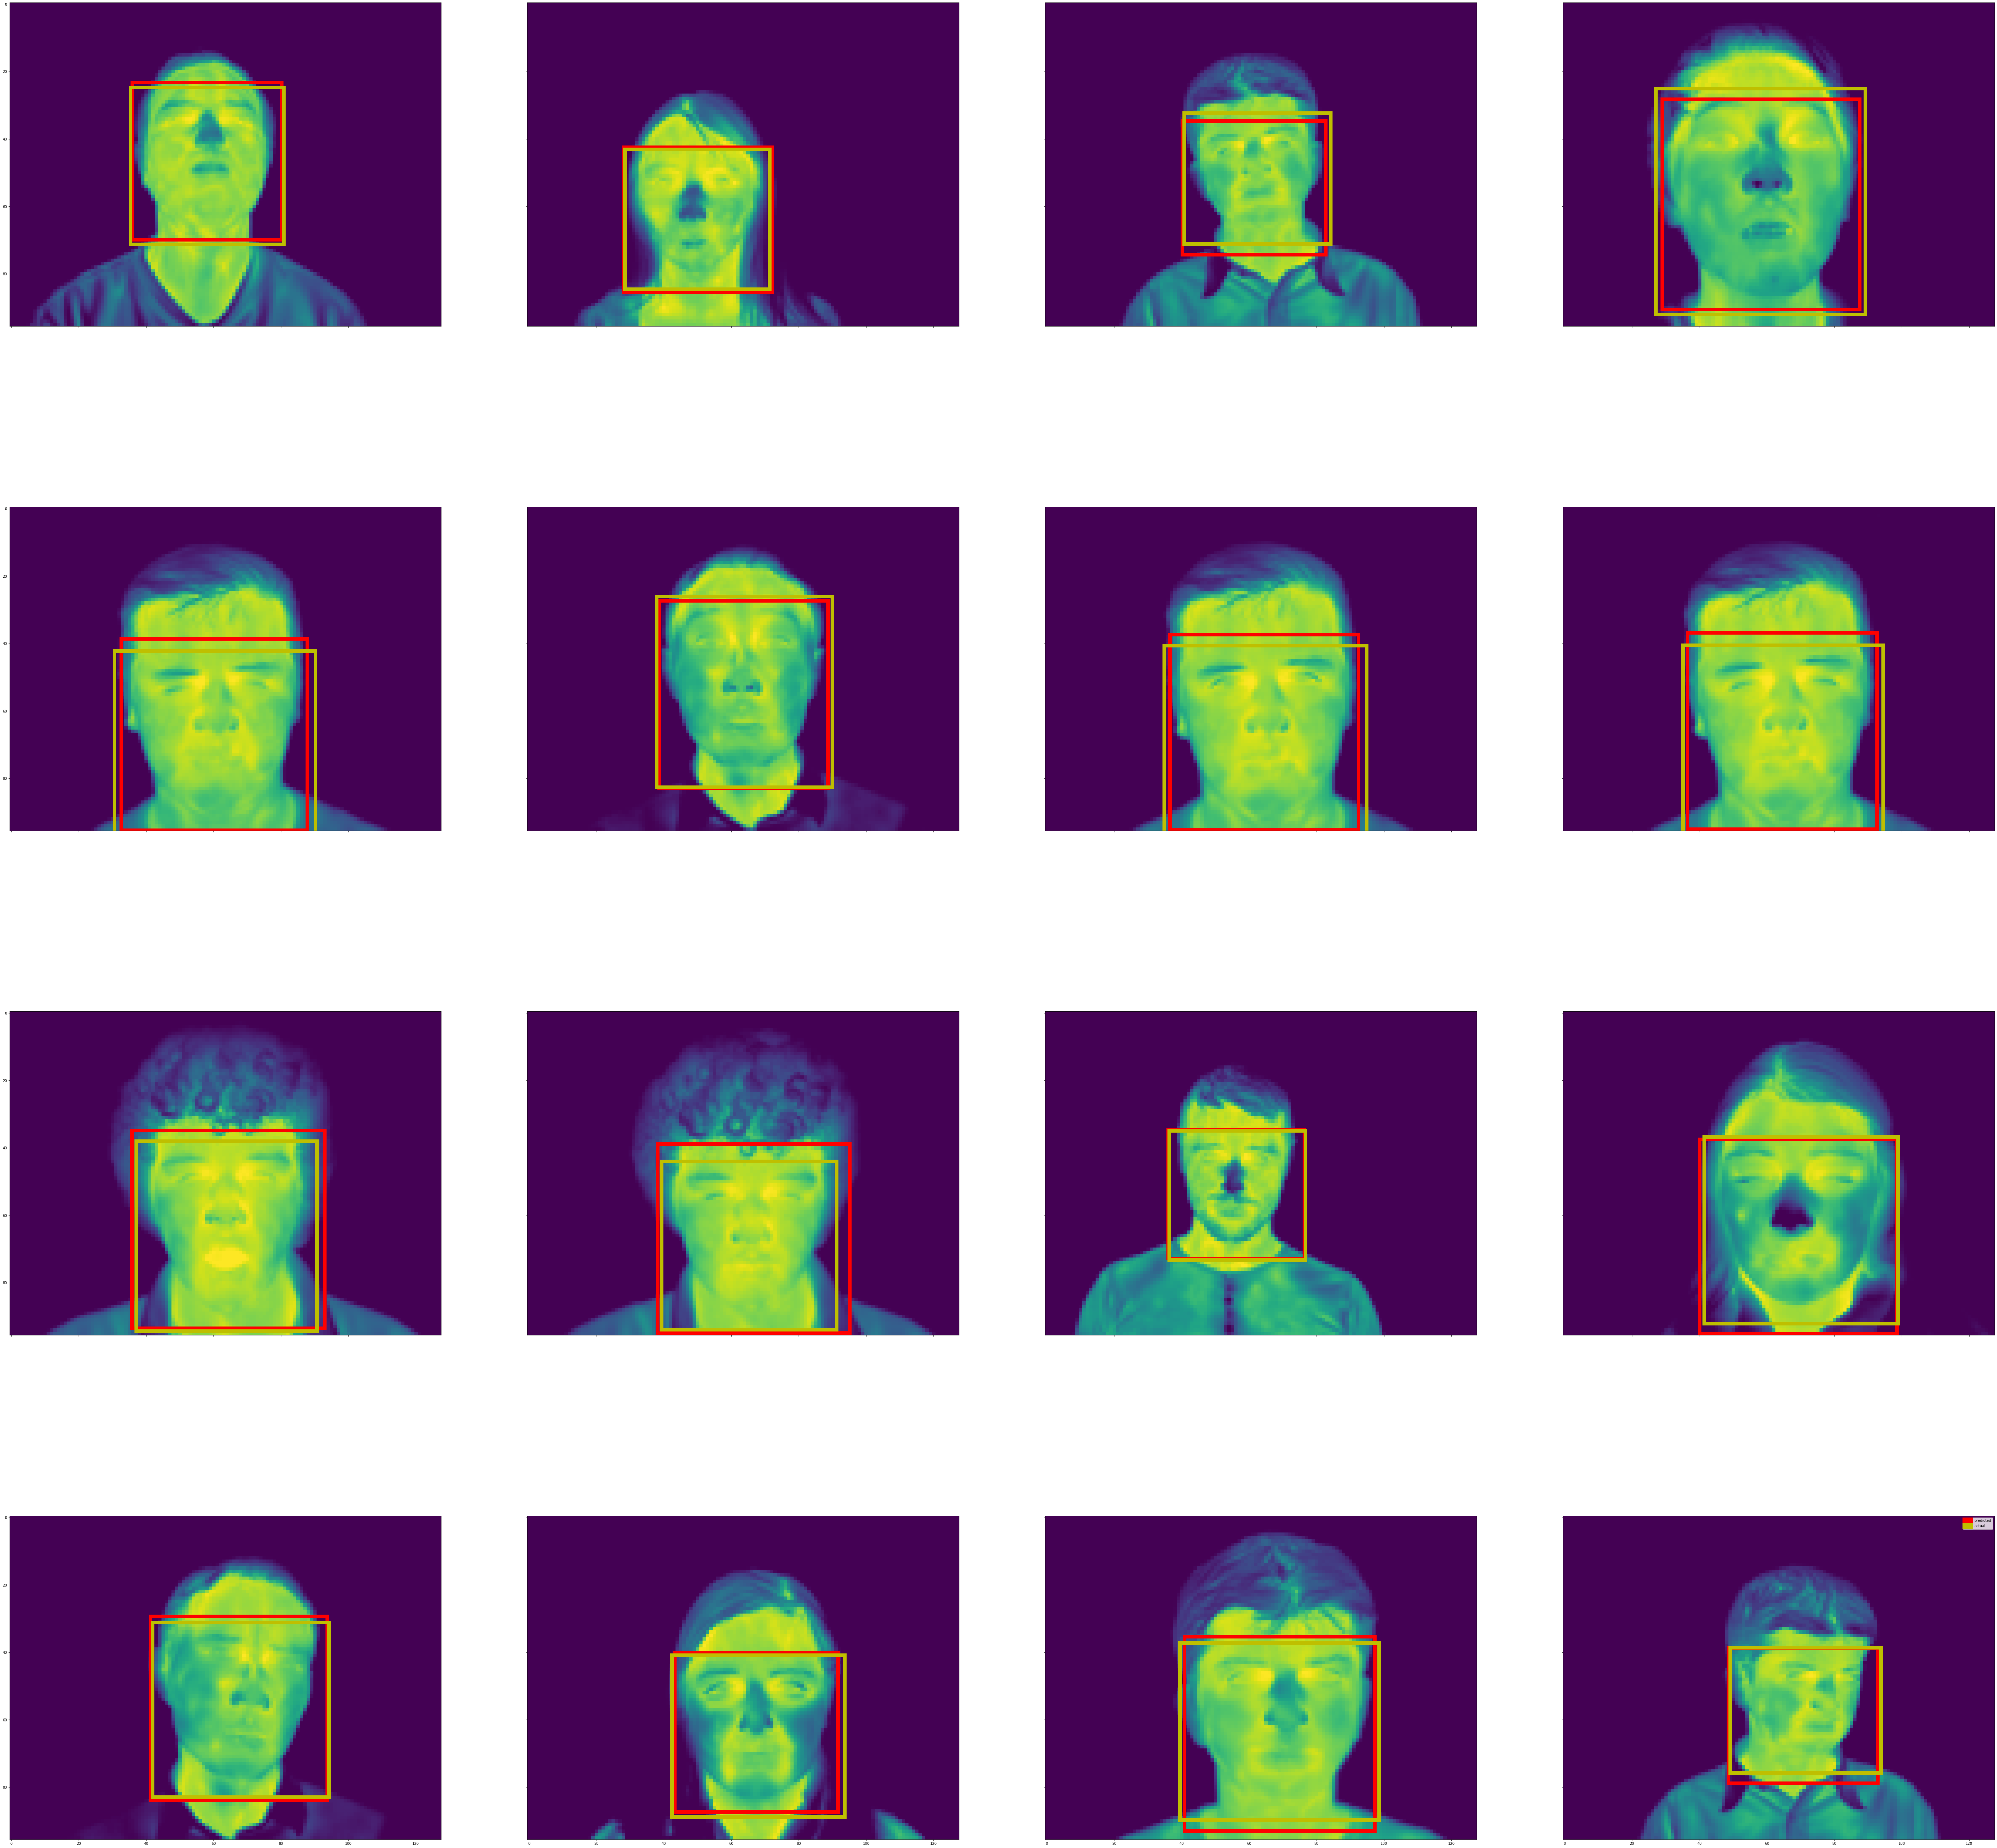

In [92]:
import tensorflow.keras.losses



y_test_pred = model3.predict(test_x)
plot_predictions(y_test_pred)


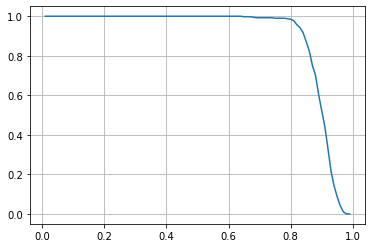

tf.Tensor(0.01379829179495573, shape=(), dtype=float64)
tf.Tensor(1.471648097038269, shape=(), dtype=float64)


In [93]:



predictions = np.zeros((y_test_pred.shape))
actual = np.zeros((test_y.shape))
predictions[:, 0], predictions[:, 1] = y_test_pred[:, 0] * SIZE_X, y_test_pred[:, 1] * SIZE_X
actual[:,0], actual[:, 1] = test_y[:,0] * SIZE_X, test_y[:, 1] * SIZE_X

predictions[:, 2], predictions[:, 3] = y_test_pred[:, 2] * SIZE_Y, y_test_pred[:, 3] * SIZE_Y
actual[:,2], actual[:, 3] = test_y[:,2] * SIZE_Y, test_y[:, 3] * SIZE_Y

intersection_over_union_set(actual, predictions)

mse = tensorflow.keras.losses.MeanAbsoluteError()
print(mse(y_test_pred, test_y))
print(mse(predictions, actual))

In [94]:
model3.save_weights('model3_augmentedData_best.h5')